In [1]:
import torch
import torch.nn as nn
# import torch.nn.functional as func
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import  DataLoader
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,),(0.5,))
])
train_set = MNIST(root="./data",train=True,download=True,transform=transform)
test_set = MNIST(root="./data",train=False,download=True,transform=transform)

batch = 64
train_loader = DataLoader(train_set,batch_size=batch,shuffle=True)
test_loader = DataLoader(test_set,batch_size=batch,shuffle=False)

cuda


In [3]:
print("number of images in the trainning dataset: ",len(train_set))
print("number of images in the testing dataset: ",len(test_set))

number of images in the trainning dataset:  60000
number of images in the testing dataset:  10000


In [4]:
print(f"shape of the images in the training dataset: {train_loader.dataset[0][0].shape}")

shape of the images in the training dataset: torch.Size([1, 28, 28])


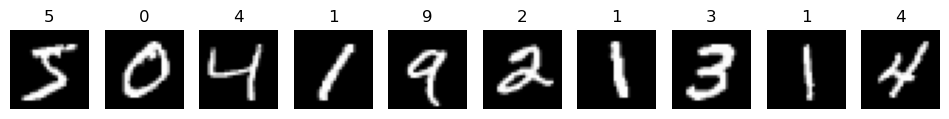

In [5]:
fig, axes = plt.subplots(1,10,figsize=(12,3))
for i in range(10):
    axes[i].imshow(train_loader.dataset[i][0].squeeze(),cmap='gray')
    axes[i].set_title(train_loader.dataset[i][1])
    axes[i].axis('off')
plt.show()

In [6]:
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network,self).__init__()
        self.fc1=nn.Linear(28*28,128)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,32)
        self.fc4=nn.Linear(32,10)
        self.relu=nn.ReLU()
        self.log= nn.LogSoftmax(dim=1)
    def forward(self,x):
        x=x.view(-1,28*28)
        x=self.relu(self.fc1(x))
        x=self.relu(self.fc2(x))
        x=self.relu(self.fc3(x))
        return self.log(self.fc4(x))

In [7]:
model = Neural_Network().to(device)
lossFunc = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.01)
epochs = 10
for epoch in range(epochs):
    for image,label in train_loader:
        image,label = image.to(device),label.to(device)
        optimizer.zero_grad()
        output=model(image)
        loss=lossFunc(output,label)
        loss.backward()
        optimizer.step()
    print(f'epoch: [{epoch+1}/{epochs}], loss: {loss.item():4f}')

epoch: [1/10], loss: 0.320941
epoch: [2/10], loss: 0.402534
epoch: [3/10], loss: 0.239731
epoch: [4/10], loss: 0.109691
epoch: [5/10], loss: 0.218372
epoch: [6/10], loss: 0.271589
epoch: [7/10], loss: 0.168753
epoch: [8/10], loss: 0.168817
epoch: [9/10], loss: 0.122578
epoch: [10/10], loss: 0.423912


In [8]:
model.eval()
all_pred = []
all_label = []
wrong_img = []
with torch.no_grad():
    for image,label in test_loader:
        image,label = image.to(device),label.to(device)
        output=model(image)
        _,pred = torch.max(output,1)
        all_pred.extend(pred.cpu())
        all_label.extend(label.cpu())
        incorred = pred != label
        if incorred.any():
            wrong = image[incorred].cpu()
            wrong_img.extend(wrong)

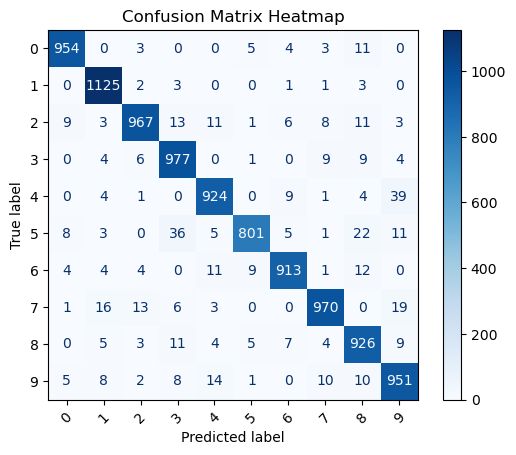

In [9]:
cm= confusion_matrix(all_label, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix Heatmap")
plt.show()

In [10]:
print("\nClassification Report:")
print(classification_report(all_label, all_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9725    0.9735    0.9730       980
           1     0.9599    0.9912    0.9753      1135
           2     0.9660    0.9370    0.9513      1032
           3     0.9269    0.9673    0.9467      1010
           4     0.9506    0.9409    0.9458       982
           5     0.9733    0.8980    0.9341       892
           6     0.9661    0.9530    0.9595       958
           7     0.9623    0.9436    0.9528      1028
           8     0.9187    0.9507    0.9344       974
           9     0.9180    0.9425    0.9301      1009

    accuracy                         0.9508     10000
   macro avg     0.9514    0.9498    0.9503     10000
weighted avg     0.9513    0.9508    0.9508     10000



In [11]:
def view_classification(image,prob):
    prob = prob.data.cpu().numpy().squeeze()
    fig, (ax1,ax2) = plt.subplots(figsize=(3,3),ncols=2)
    ax1.imshow(image.cpu().numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10),prob)
    ax2.set_aspect('auto')
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('class probability')
    ax2.set_xlim(0,1)
    plt.tight_layout()

492


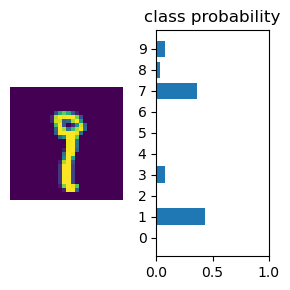

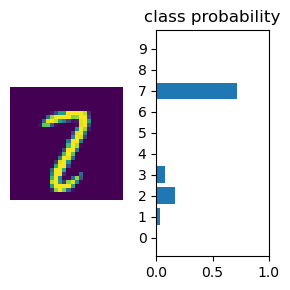

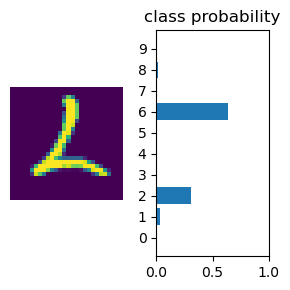

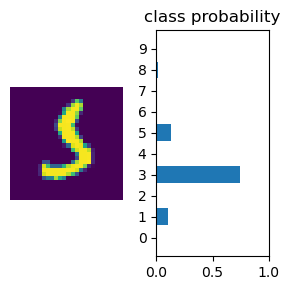

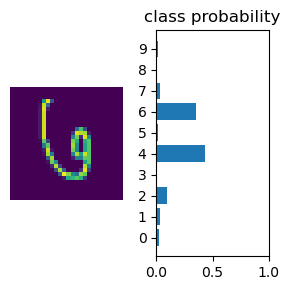

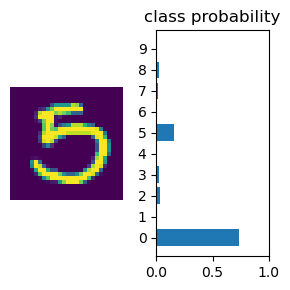

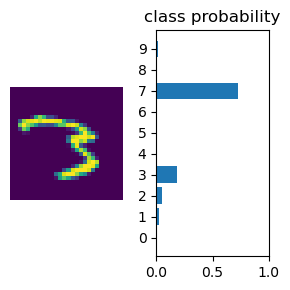

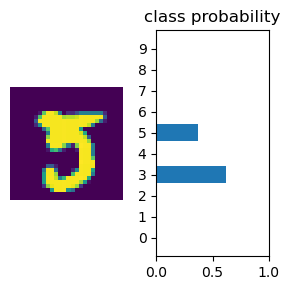

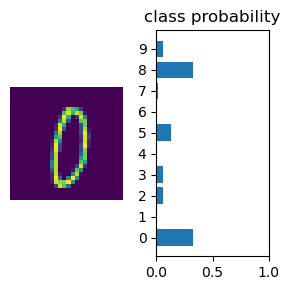

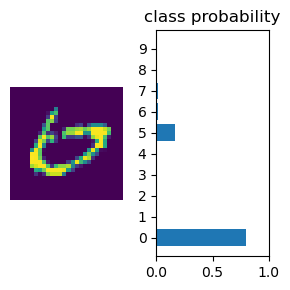

In [12]:
print(len(wrong_img))
images= wrong_img#next(iter(test_loader))
for i in range(10):
    image = images[i+12]
    image = image.to(device)
    # image = image.unsqueeze(0)
    with torch.no_grad():
        log_prob=model(image)
    probabilities = torch.exp(log_prob)
    view_classification(image.view(1,28,28),probabilities)